# 1D Helmholtz Two-Level LFA

In [102]:
# k_values = [0, 0.5]
# discretizations = ("3-point", "5-point")
# fig, axs = plt.subplots(1, len(k_values), figsize=(6 * len(k_values), 4))
# for j, k in enumerate(k_values):
#     ax = axs[j]
#     ax.plot(t, np.abs(-t ** 2 + k), label="PDE")
#     for i, discretization in enumerate(discretizations):
#         at = symbols(k, discretization=discretization)[0]
#         ax.plot(t, np.abs(at), label=discretization)
#     ax.grid(True)
#     ax.set_title("{}, k {:.2f}".format(discretization, k))
#     ax.set_ylim([0, 5])
#     ax.legend();

# k_values = [0, 0.5]
# discretizations = ("3-point", "5-point")
# fig, axs = plt.subplots(len(discretizations), len(k_values), 
#                         figsize=(6 * len(k_values), 4 * len(discretizations)))
# for i, discretization in enumerate(discretizations):
#     for j, k in enumerate(k_values):
#         at, gs, kac = symbols(k, discretization=discretization)
#         ax = axs[i, j]
#         ax.plot(t, gs)
#         ax.plot(t, kac)
#         print(gs[0], kac[0])
#         ax.grid(True)
#         ax.set_title("{}, k {:.2f}".format(discretization, k))
#         ax.set_ylim([0.3, 1.3])

# discretizations = ("3-point", )# "5-point")
# rho_values = [0.5, 1/3]
# k_values = np.linspace(0, 1, num=10)
# nk = len(k_values)
# nr = len(rho_values)

# fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# for i, discretization in enumerate(discretizations):
#     mu_gs = np.zeros((nk, nr))
#     mu_kac = np.zeros((nk, nr))
#     bmu1_gs = np.zeros((nk, nr))
#     bmu1_kac = np.zeros((nk, nr))
#     bmu2_gs = np.zeros((nk, nr))
#     bmu2_kac = np.zeros((nk, nr))

#     for j, k in enumerate(k_values):
#         at, gs, kac = symbols(k, discretization=discretization)
#         mu_gs[j] = max(abs(gs))
#         mu_kac[j] = max(abs(kac))
#         for r, rho in enumerate(rho_values):
#             bmu1_gs[j, r] = smoothing_factor(at, gs, rho)
#             bmu1_kac[j, r] = smoothing_factor(at, kac, rho)
#             bmu2_gs[j, r] = smoothing_factor(at, gs, rho, kind="svd")
#             bmu2_kac[j, r] = smoothing_factor(at, kac, rho, kind="svd")

#     for r, rho in enumerate(rho_values):
#         ax = axs[r]
#         ax.plot(k_values, bmu1_gs[:, r], label="GS, {} rho {:.2f}".format(discretization, rho))
#         ax.plot(k_values, bmu1_kac[:, r], label="Kaczmarz, {} rho {:.2f}".format(discretization, rho))
#         ax.grid(True)
#         ax.set_title("Smoothing Factor");
#         ax.legend() # loc="lower right");
#         ax.set_ylim([0.4, 1])

# #     ax = axs[1]
# #     ax.plot(k_values, mu_gs, label="GS, {}".format(discretization))
# #     ax.plot(k_values, mu_kac, label="Kaczmarz, {}".format(discretization))
# #     ax.grid(True)
# #     ax.set_title("Convergence Factor");
# #     ax.set_ylim([0.9, 1.2])
# #     ax.legend();

In [69]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from numpy import pi

In [ ]:
def block_diagonal_tensor(*x):
    n = len(x[0])
    j = np.arange(n, dtype=int)
    result = np.zeros((n, 2, 2))
    for i, xi in enumerate(x):
        result[j, i, i] = xi
    return result

In [205]:
t = np.linspace(-pi, pi, 100) + 1e-13
k = 0
discretization = "3-point"

def gs_symbol(a, t):
    """a must be odd, centered at len(a) // 2."""
    mid = len(a) // 2
    left = np.poly1d(a.c[:mid + 1])
    right = np.poly1d(np.concatenate((a.c[mid + 1:][::-1], [0])))
    r = np.abs(right(np.exp(1j * t)) / left(np.exp(-1j * t)))
    return r

def a_poly():
    if discretization == "3-point":
        a = np.array([1, -2 + k ** 2, 1])
    elif discretization == "5-point":
        a = np.array([-1, 16, -30 + 12 * k ** 2, 16, -1])
    else:
        raise Exception("Unsupported discretization type")
    return np.poly1d(a)

def a(t):
    stencil = a_poly()
    return np.real(np.exp(-1j * t * (len(stencil) // 2)) * stencil(np.exp(1j * t)))

def gs(t):
    return gs_symbol(a_poly(), t)

def kaczmarz(t):
    # A is symmetric, so A*A' = A^2.
    stencil = a_poly()
    return gs_symbol(np.polymul(stencil, stencil), t)

def diag_harmonics(symbol, t):
    return block_diagonal_tensor(symbol(t), symbol(t + pi))

def r(t):
    return 1 + np.exp(1j * t)

def r_harmonics(t):
    R = np.array([r(t), r(t + pi)])
    return np.rollaxis(R[None, :], 2, 0)

def p_harmonics(t):
    return np.swapaxes(r_harmonics(t), 1, 2)

def ac(t):
    A = a(t)
    R = r_harmonics(t)
    P = p_harmonics(t)
    return (R.dot(A)).dot(P)

def clc(t):
    A = diag_harmonics(a, t)
    R = r_harmonics(t)
    P = p_harmonics(t)
    # Galerkin coarsening.
    RA = np.matmul(R, A)
    AC = np.matmul(RA, P)
    b = np.linalg.solve(AC, RA)
    return np.tile(np.eye(2), (len(t), 1, 1)) - np.matmul(P, b)

def two_level_cycle(t, nu):
    return clc(t).dot(diag_harmonics(kaczmarz, t) ** nu)

In [207]:
two_level_cycle(t, 2)

LinAlgError: Singular matrix

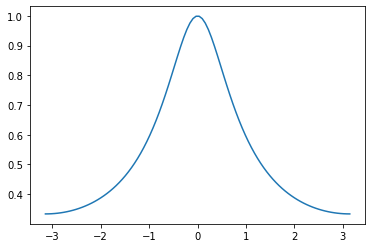

In [204]:
plt.plot(t, gs(t))

In [208]:
A = diag_harmonics(a, t)
R = r_harmonics(t)
P = p_harmonics(t)
# Galerkin coarsening.
RA = np.matmul(R, A)
AC = np.matmul(RA, P)
print(AC.shape, RA.shape)

(100, 1, 1) (100, 1, 2)


In [209]:
b = np.linalg.solve(AC, RA)

LinAlgError: Singular matrix